# Toy Example

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10 as cf10
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.1


In [6]:
(train_images, train_labels), (test_images, test_labels) = cf10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [10]:
import matplotlib.pyplot as plt

def show_images(train_images, class_names, train_labels, nb_samples=12, nb_row=4):
    plt.figure(figsize=(12, 12))
    for i in range(nb_samples):
        plt.subplot(nb_row, nb_row, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i][0]])
    plt.show()


### Print data to check it is ok

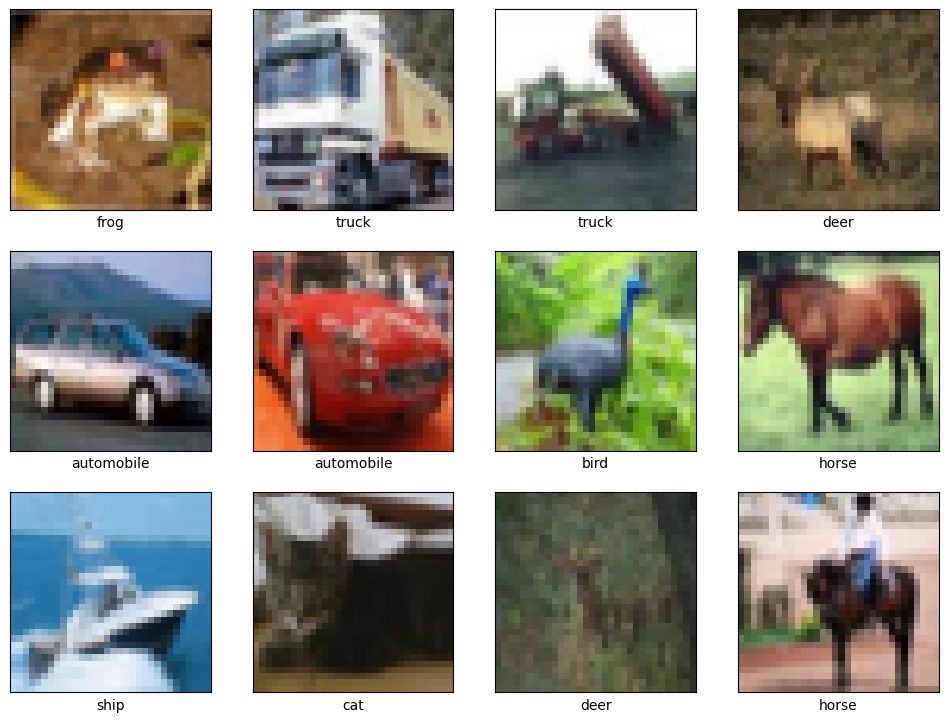

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           	'dog', 'frog', 'horse', 'ship', 'truck']

show_images(train_images, class_names, train_labels)

### Normalize data

In [12]:
max_pixel_value = 255

train_images = train_images / max_pixel_value
test_images = test_images / max_pixel_value

### Make labels numerical

In [13]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, len(class_names))
test_labels = to_categorical(test_labels, len(class_names))

### Define Model

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Variables
INPUT_SHAPE = (32, 32, 3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(class_names)

# Model architecture implementation
model = Sequential()
model.add(Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation='relu'))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

### Train Model

In [15]:
from tensorflow.keras.metrics import Precision, Recall

BATCH_SIZE = 32
EPOCHS = 30

METRICS = metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')]

model.compile(optimizer='adam',
          	loss='categorical_crossentropy',
          	metrics = METRICS)

# Train the model
training_history = model.fit(train_images, train_labels,
                	epochs=EPOCHS, batch_size=BATCH_SIZE,
                	validation_data=(test_images, test_labels))

Epoch 1/30
1563/1563 [==============================] - 23s 14ms/step - loss: 1.4407 - accuracy: 0.4819 - precision: 0.7040 - recall: 0.2588 - val_loss: 1.2654 - val_accuracy: 0.5539 - val_precision: 0.7164 - val_recall: 0.3955
Epoch 2/30
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0824 - accuracy: 0.6210 - precision: 0.7621 - recall: 0.4697 - val_loss: 1.0398 - val_accuracy: 0.6387 - val_precision: 0.7644 - val_recall: 0.4934
Epoch 3/30
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9448 - accuracy: 0.6699 - precision: 0.7855 - recall: 0.5502 - val_loss: 0.9719 - val_accuracy: 0.6628 - val_precision: 0.7664 - val_recall: 0.5586
Epoch 4/30
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8434 - accuracy: 0.7059 - precision: 0.8076 - recall: 0.6081 - val_loss: 0.9295 - val_accuracy: 0.6793 - val_precision: 0.7706 - val_recall: 0.5928
Epoch 5/30
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7667 - a

## Evaluate model 

### Performance curve

In [16]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
	intersection_idx = np.argwhere(np.isclose(train_perf,
                                            	validation_perf, atol=1e-2)).flatten()[0]
	intersection_value = train_perf[intersection_idx]
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
         	xy=(intersection_idx, intersection_value),
         	xycoords='data',
         	fontsize=10,
         	color='green')
            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

In [17]:
show_performance_curve(training_history, 'accuracy', 'accuracy')



NameError: name 'np' is not defined

In [ ]:
show_performance_curve(training_history, 'precision', 'precision')



### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predictions = model.predict(test_images)

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()